In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.close_figures=False 

import os, sys
sys.path.append(os.path.abspath(os.path.join('../')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import linear_model
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns 
from mlmodels.model import *
from mlmodels.linear_models import *
from mlmodels.treebased_models import *
from helper_libraries.model_pipeline import *
from helper_libraries.forecasting_tools import *
from helper_libraries.preprocessing_tools import *
from tqdm.auto import tqdm
import datetime as dt
import sklearn.preprocessing
import sklearn.utils
import unittest

sns.set_context("paper", font_scale=1.7)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

# Outline

* Load some sample data for testing
* Run tests on various classes and functions

# Load Data

In [2]:
# Set up some sample data for the tests
sample_data_df = pd.read_parquet('../../data/proc/_temp/1996_all.parquet')

# Load data
iris_df = sns.load_dataset('iris')
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Tests - Pipeline

In [12]:
# Set up in sample data
np.random.seed(1)
ins_frac = 0.1
iris_ins_df = iris_df.sample(70).reset_index(drop = True)
iris_oos_df = iris_df.sample(70).reset_index(drop = True)

Y_ins = iris_ins_df[['petal_length']]
X_ins = iris_ins_df[['petal_width', 'sepal_length', 'sepal_width']]
Y_oos = iris_oos_df[['petal_length']]
X_oos = iris_oos_df[['petal_width', 'sepal_length', 'sepal_width']]

# Run models
model_lasso = LASSO({'lambda': 1e-5, 'use_intercept': False, 'seed': 5})
model_lr = LinearRegression({})
model_rf = RandomForest(hyperparameters = None)
model_list = [model_lasso, model_lr, model_rf]

# Split into train/validate for optimal hyperparams
mtrain = ModelTrainer(model_list, Y_ins, X_ins, seed = 444)
mtrain.validation(frac=0.5, n_iter_default = 10)
mtrain.model_hyperparameters_opt[0]['n_tree'] = 1

# Testing
mtest = ModelTester(mtrain)
model_forecasts, model_params = mtest.forecast(Y_oos, X_oos)

## View results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   true   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.830e+04
Date:                Fri, 03 Dec 2021   Prob (F-statistic):                    2.03e-85
Time:                        16:36:26   Log-Likelihood:                         -6.1627
No. Observations:                  70   AIC:                                      14.33
Df Residuals:                      69   BIC:                                      16.57
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
forecast       1.0145      0.007    135.292      0.000       1.000       1.029
==============================================================================
Omnibus:                        7.658   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.977
Skew:                           0.686   Prob(JB):                       0.0305
Kurtosis:                       3.713   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='forecast', ylabel='true'>

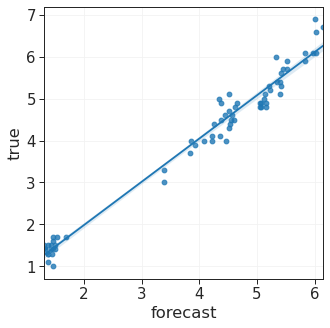

In [4]:
model_index = 2
results_df = pd.concat(
    [
        model_forecasts[model_index].rename(columns={"petal_length": "forecast"}),
        Y_oos.rename(columns={"petal_length": "true"}),
        X_ins['petal_width'], 
    ],
    axis=1,
)

display(smf.ols('true ~ forecast - 1', data = results_df).fit().summary())

fig, ax = plt.subplots(figsize = (5,5))
sns.regplot(x = 'forecast', y = 'true', data = results_df, ax  = ax)

<AxesSubplot:xlabel='petal_width', ylabel='forecast'>

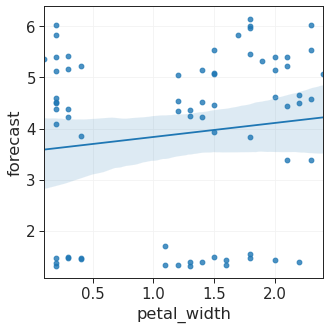

In [5]:
fig, ax = plt.subplots(figsize = (5,5))
sns.regplot(x = 'petal_width', y = 'forecast', data = results_df, ax  = ax)

## Unit Tests
Use this only after running full pipeline

In [6]:
# class TestPipelineFunctions(unittest.TestCase):
    
#     def test_scaling(self):

#         mtrain = ModelTrainer([model_lasso], Y_ins, X_ins, seed = 444)
#         mtrain.validation(frac=0.5, n_iter=2)
#         self.assertEqual(np.all(np.std(mtrain.X_train_scl, axis = 0)==1), 1)
    
#     def test_somethingelse(self):

#         self.assertEqual(3.14, 3.14)

In [7]:
# unittest.main(argv=[''], verbosity=2, exit=False);

# Tests - Preprocessing Tools

In [20]:
# Params
factors = ["cz__bpebm"]

## Prep
# Smaller sample of the full data
data_sample_df = sample_data_df.loc["1996-01":"1996-06"].loc[:,factors].copy()

# Add date column - needed for adding lagged averages
data_sample_df["date"] = pd.to_datetime(data_sample_df.index.date)

## Add lagged measures
data_sample_df = add_lagged_intradaily_averages(
    data_sample_df, factors, "1h", 1
)
data_sample_df = add_lagged_intradaily_averages(
    data_sample_df, factors, "1h", 2
)
data_sample_df = add_lagged_daily_averages(
    data_sample_df, factors, "1d", 1
)
data_sample_df = add_lagged_daily_averages(
    data_sample_df, factors, "1d", 2
)

# View some of the data
data_sample_df.dropna().head(40).tail(20)

,cz__bpebm,date,cz__bpebm_1h_1_lagged_intradaily_avg,cz__bpebm_1h_2_lagged_intradaily_avg,cz__bpebm_1d_1_lagged_daily_avg,cz__bpebm_1d_2_lagged_daily_avg
datetime,,,,,,
1996-01-04 14:30:00,0.000650,1996-01-04,0.000186,0.000043,-0.000324,-0.000166
1996-01-04 14:45:00,0.000580,1996-01-04,0.000309,0.000186,-0.000324,-0.000166
1996-01-04 15:00:00,-0.000514,1996-01-04,0.000306,0.000309,-0.000324,-0.000166
1996-01-04 15:15:00,-0.000262,1996-01-04,0.000134,0.000306,-0.000324,-0.000166
1996-01-04 15:30:00,0.000542,1996-01-04,0.000114,0.000134,-0.000324,-0.000166
1996-01-04 15:45:00,0.001515,1996-01-04,0.000087,0.000114,-0.000324,-0.000166
1996-01-04 16:00:00,-0.000344,1996-01-04,0.000320,0.000087,-0.000324,-0.000166
1996-01-05 09:30:00,-0.003862,1996-01-05,0.000363,0.000320,-0.000268,-0.000324
1996-01-05 09:45:00,-0.000887,1996-01-05,-0.003862,0.000363,-0.000268,-0.000324


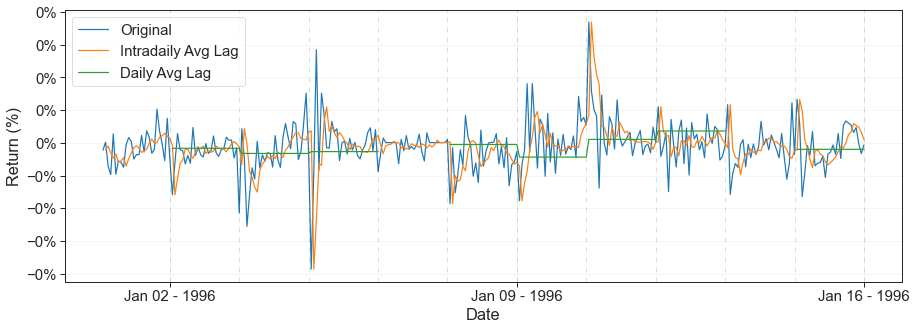

In [21]:
fig, ax = plt.subplots(figsize = (15,5))

# Sample dataframe for plotting
plot_df = data_sample_df.loc[data_sample_df.index < (data_sample_df.index[0] + pd.Timedelta('15d'))]

plot_df[factors[0]].reset_index(drop = True).plot(label = 'Original', ax = ax)
plot_df[factors[0] + '_1h_1_lagged_intradaily_avg'].reset_index(drop = True).plot(label = 'Intradaily Avg Lag', ax = ax)
plot_df[factors[0] + '_1d_1_lagged_daily_avg'].reset_index(drop = True).plot(label = 'Daily Avg Lag', ax = ax)


# Lines for each day
sample_index_df = plot_df.reset_index().reset_index().groupby(pd.Grouper(key = 'datetime', freq = '1d')).last()['index'].dropna()
for key, val in sample_index_df.to_frame().iterrows():
    ax.axvline(x = val.iloc[0], color = 'k', lw = 0.5, ls = (0,(10,10)), alpha = 0.25)

ax.set_xticks(sample_index_df.iloc[::5].values)
ax.set_xticklabels(sample_index_df.iloc[::5].index.strftime('%b %d - %Y'))
ax.set_xlabel(f"Date-Time Index (0 = {plot_df.reset_index()['datetime'].iloc[0]})")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.set_ylabel('Return (%)')
ax.set_xlabel('Date')
ax.legend()

# Tests - Forecasting Tools

## Full Example

In [10]:
## Example params

# Create some models
model_lasso = LASSO({'lambda': 1e-5, 'use_intercept': False, 'seed': 5}, n_iter = 10)
model_lasso2 = LASSO({'lambda': 1e-5, 'use_intercept': False, 'seed': 5}, n_iter = 10)
model_list = [model_lasso, model_lasso2]

# Define your data
Y = sample_data_df[['ff__mkt']]
X = sample_data_df[['ff__hml', 'ff__smb', 'ff__rmw', 'ff__cma', 'ff__umd']].shift(1).bfill()

In [11]:
# This function is passed into the produce_forecasts_*** function
# and applied on whatever basis
def forecasting_pipeline(model_list, Y_ins, X_ins, Y_oos, X_oos):
    
    # Output variables
    forecast_log = {}
    
    # Train the algos
    mtrain = ModelTrainer(model_list, Y_ins, X_ins, seed=444)
    mtrain.validation()
    forecast_log['hyperparameters'] = mtrain.model_hyperparameters_opt

    # Produce OOS forecasts
    mtest = ModelTester(mtrain)
    oos_forecasts = mtest.forecast(Y_oos, X_oos)
    forecast_output = oos_forecasts
    
    return forecast_output, forecast_log

In [19]:
## Rolling implementation of models to get rolling forecasts
forecast_output, forecast_log = produce_forecasts_rolling(
    Y,
    X,
    model_list,
    forecasting_pipeline,
    ins_window="30d",
    oos_window="5d",
    disable_progress_bar=False,
)

  0%|          | 0/67 [00:00<?, ?it/s]

### View results

In [14]:
# Params
model_index = 0

In [16]:
# # Each element of this list contains a dataframe of forecasts
# # for a particular model in model_list
# forecast_output_list = [pd.concat(pd.DataFrame(forecast_output).T[col].values) for col in range(len(model_list))]

# # Get forecasts for the first model
# model_forecasts_example_df = forecast_output_list[model_index]
# model_forecasts_example_df = (
#     model_forecasts_example_df.reset_index()
#     .merge(Y.reset_index(), on="datetime", suffixes=("_forecast", "_truth"), how="left")
#     .set_index("datetime")
# )
# display(
#     sm.OLS(model_forecasts_example_df.iloc[:, 1], model_forecasts_example_df.iloc[:, 0]).fit().summary()
# )
# fig, ax = plt.subplots(figsize = (15,5))
# model_forecasts_example_df.plot(alpha = 0.5, lw = 2, ax= ax);

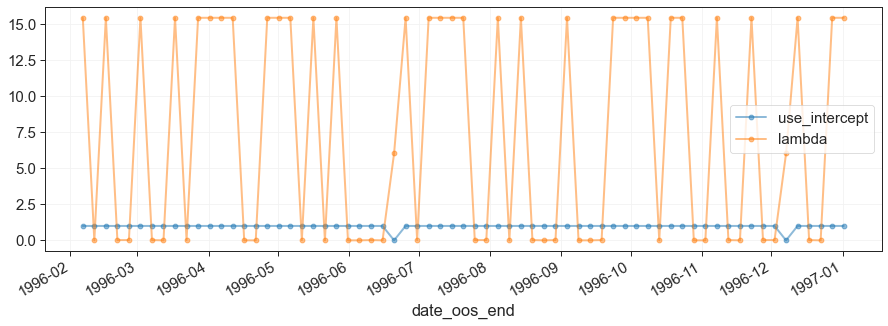

In [17]:
## Forecast log
forecast_log_df = pd.DataFrame(forecast_log).T
model_select_lambda_opt = (
    forecast_log_df["hyperparameters"]
    .apply(lambda x: x[model_index].get("lambda"))
    .to_frame(name="lambda")
    .set_index(forecast_log_df["date_oos_end"])
)
model_select_interceptarg_opt = (
    forecast_log_df["hyperparameters"]
    .apply(lambda x: x[model_index].get("use_intercept"))
    .astype(int)
    .to_frame(name="use_intercept")
    .set_index(forecast_log_df["date_oos_end"])
)

fig, ax = plt.subplots(figsize=(15, 5))
model_select_interceptarg_opt["use_intercept"].plot(alpha=0.5, lw=2, marker="o", label="use_intercept", ax=ax)
model_select_lambda_opt["lambda"].plot(alpha=0.5, lw=2, marker="o", label="lambda", ax=ax)
ax.legend();

## Check rolling windows
Visualize the windows used by the produce_forecasts_*** functions
Can specify expanding kwarg as true or false

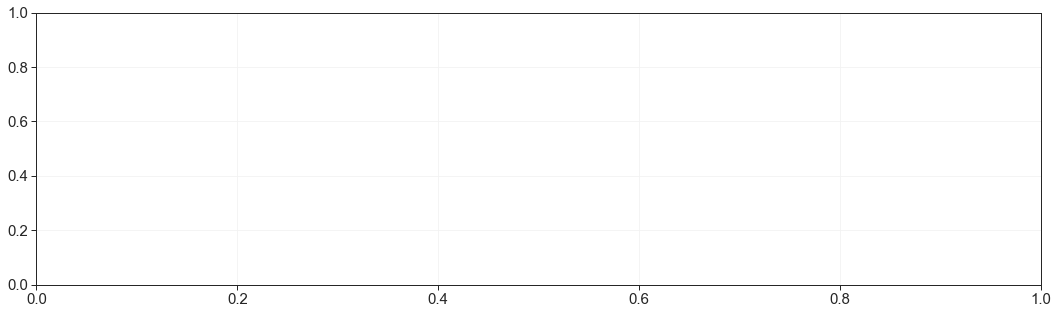

NameError: name 'Y' is not defined

In [3]:
# Set up figure
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(111)
plt.close()
hfig = display(fig, display_id=True)

# Params
date_zero = Y.index[0]
date_stop = Y.index[-1]

# Initial draw
ax.plot([date_zero, date_stop], [0, 0], color="k", alpha=0.5, lw=1)
ax.set_xlim(date_zero, date_stop)
ax.set_yticks([])
fig.canvas.draw()
hfig.update(fig)

# This function plots the windows using the indices of the
# in-sample and out-of-sample data
def plot_windows(_, Y_ins, X_ins, Y_oos, X_oos):
    
    # Get windows
    date_ins_start = Y_ins.index[0]
    date_ins_end = Y_ins.index[-1]
    date_oos_start = Y_oos.index[0]
    date_oos_end = Y_oos.index[-1]

    # Plot new windows
    ax.cla()
    import time
    ax.axvspan(date_ins_start, date_ins_end, color="r", alpha=0.5, label="Training Data", lw=0)
    ax.axvspan(date_oos_start, date_oos_end, color="b", alpha=0.5, label="Testing Data", lw=0)
    ax.axvspan(date_ins_end, date_oos_start, color="silver", alpha=0.5, label="(Overnight)", lw=0)
    ax.plot([date_zero, date_stop], [0, 0], color="k", alpha=0.5, lw=1, zorder= -1)
    ax.set_xlim(date_zero, date_stop)
    ax.set_yticks([])
    ax.legend(loc="upper left")

    # Update figure
    fig.canvas.draw_idle()
    time.sleep(0.01)
    hfig.update(fig)
    
    return None, {}

# Rolling implementation of models to get rolling forecasts
forecast_output, forecast_log = produce_forecasts_rolling(
    Y, X, model_list, plot_windows, ins_window="30d", oos_window="5d", expanding = False
)